In [177]:
import numpy as np 
import pandas as pd 

import json
import time
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import itertools

#from mpl_toolkits.basemap import Basemap

import gc
import os
print(os.listdir("."))

['.DS_Store', 'input', 'Assignment-1.pdf', '.ipynb_checkpoints', 'electricity-demand-prediction.ipynb']


In [178]:
in_file_name = "Home1_yr1.csv"
out_file_name = "home1_out.csv"

In [179]:
column_names = ['load_demand']
house_data = pd.read_csv("./input/" + in_file_name, low_memory=False, nrows=None, names=column_names)
house_data.shape

(35040, 1)

In [180]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 1 columns):
load_demand    35040 non-null float64
dtypes: float64(1)
memory usage: 273.8 KB


In [181]:
house_data.describe()

,load_demand
count,35040.000000
mean,1.327208
std,1.399019
min,0.015124
25%,0.315678
50%,0.722875
75%,1.988425
max,15.500000


In [182]:

epochTime = 1417392000

def get_time_stamp(row):
    global epochTime
    epochTime+=900
    return pd.to_datetime(epochTime,unit='s')

house_data['time_stamp'] = house_data.apply (lambda row: get_time_stamp(row),axis=1)


In [183]:
house_data.head(10)

,load_demand,time_stamp
0,0.65018,2014-12-01 00:15:00
1,1.45400,2014-12-01 00:30:00
2,0.72971,2014-12-01 00:45:00
3,3.10750,2014-12-01 01:00:00
4,0.63572,2014-12-01 01:15:00
5,0.69720,2014-12-01 01:30:00
6,1.50610,2014-12-01 01:45:00
7,0.85858,2014-12-01 02:00:00
8,1.61320,2014-12-01 02:15:00
9,0.66075,2014-12-01 02:30:00


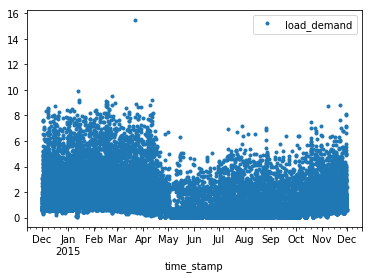

In [184]:
house_data.plot('time_stamp', 'load_demand', style=".")

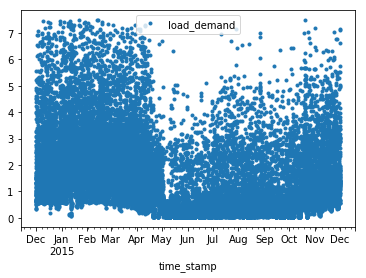

In [185]:
mean = house_data.loc[house_data['load_demand']<7.5, 'load_demand'].mean()
house_data["load_demand"] = np.where(house_data["load_demand"] >=7.5, mean, house_data['load_demand'])
house_data.plot('time_stamp', 'load_demand', style=".")

In [186]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-12-01', end='2015-11-30').to_pydatetime()

#get hour:minute format
def hour_minute(row_data):
    return (row_data.time_stamp.hour) #* 100 + (row_data.pickup_datetime.minute)

#get day_of_week format
def day_of_week(row_data):
    return (row_data.time_stamp.weekday())

def check_holiday(row_data):
    strip_date = datetime.datetime.strptime((str(row_data.time_stamp)[:10] ),'%Y-%m-%d')
    return 1 if strip_date in holidays else 0

#get month format
def get_month(row_data):
    return (row_data.time_stamp.month)

house_data['time_of_day'] = house_data.apply(lambda row: hour_minute(row), axis=1)
house_data['day_of_week'] = house_data.apply(lambda row: day_of_week(row), axis=1)
house_data['holiday'] = house_data.apply(lambda row: check_holiday(row), axis=1)
house_data['month_of_year'] = house_data.apply(lambda row: get_month(row), axis=1)
house_data['slot'] = np.array([i for i in range(1,len(house_data)+1)]).reshape(-1, 1)
house_data_copy = house_data.copy()
del house_data['time_stamp']

house_data.head(10)

,load_demand,time_of_day,day_of_week,holiday,month_of_year,slot
0,0.65018,0,0,0,12,1
1,1.45400,0,0,0,12,2
2,0.72971,0,0,0,12,3
3,3.10750,1,0,0,12,4
4,0.63572,1,0,0,12,5
5,0.69720,1,0,0,12,6
6,1.50610,1,0,0,12,7
7,0.85858,2,0,0,12,8
8,1.61320,2,0,0,12,9
9,0.66075,2,0,0,12,10


In [187]:
#get day_of_week format

#house_data.time_stamp[0].month

In [188]:
#Naive model

def Naive_Model(X):
    return X[-96:]

def Mean_Absolute_Error(x, y):
    return sum([abs(x[i] - y[i]) for i in range(len(y))])/(len(y) * 1.0)

day_value = 300
interval_count = day_value * 96
column = house_data.columns[0]
#print(house_data[column].values)
X_train = house_data[column].values[:interval_count]
X_test = house_data[column].values[interval_count:interval_count+96]
y = Naive_Model(X_train)
#print(X_test, y)
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, y))

Mean Absolute Error : 0.51548


In [189]:
#Linear Regression without additional features
linear_regression = LinearRegression()
final_columns = house_data.columns

linear_reg_train_X = np.array([i for i in range(1,len(X_train)+1)]).reshape(-1, 1)
linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
linear_reg_test_X = np.array([len(X_train)+i for i in range(1,len(X_test)+1)]).reshape(-1, 1)
linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(final_columns,linear_regression.coef_)])
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))


Coefficients (a,b,c,..) :  [('load_demand', -8.4198401384596536e-05)]
Mean squared error: 1.17630
Variance : -0.36708
Mean Absolute Error : 0.57346


In [190]:
#Linear Regression with additional features
day_value = 300
interval_count = day_value * 96
column = house_data.columns[0]
linear_regression = LinearRegression()
final_columns = house_data.columns[1:]

linear_reg_train_X = house_data[final_columns][:interval_count]
linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
linear_reg_test_X = house_data[final_columns][interval_count:interval_count+96]
linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(final_columns,linear_regression.coef_)])
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))

Coefficients (a,b,c,..) :  [('time_of_day', 0.043424973524714777), ('day_of_week', -0.0048698105394367969), ('holiday', -0.024756739021468452), ('month_of_year', -0.068364709603470047), ('slot', -7.6844183635202068e-05)]
Mean squared error: 1.23050
Variance : -0.43006
Mean Absolute Error : 0.75020


In [191]:
from fbprophet import Prophet

df = pd.DataFrame({"ds":house_data_copy["time_stamp"].values})
df['y'] = house_data_copy['load_demand']
df.reset_index(drop=False,inplace=True)

fed_holiday = pd.DataFrame({"ds":house_data_copy["time_stamp"].values})
fed_holiday['holiday'] = house_data_copy['holiday']
fed_holiday = fed_holiday[fed_holiday['holiday'] == 1]

fed_holiday['holiday'] = fed_holiday.apply(lambda row: 'holiday', axis=1)

m = Prophet(yearly_seasonality=True, holidays=fed_holiday)
m.fit(df)

future = m.make_future_dataframe(periods=24 * 60, freq='min')
#print(future)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
36475,2015-12-01 23:56:00,1.541398,0.278703,2.833993
36476,2015-12-01 23:57:00,1.537175,0.185253,2.859492
36477,2015-12-01 23:58:00,1.532963,0.273795,2.811800
36478,2015-12-01 23:59:00,1.528763,0.157406,2.879679
36479,2015-12-02 00:00:00,1.524576,0.161413,2.887607


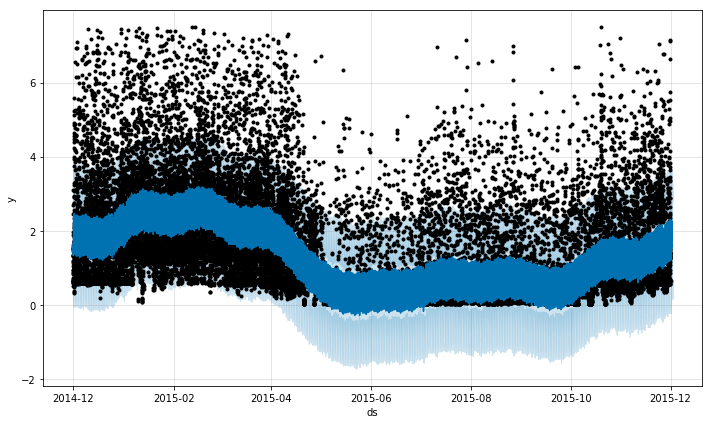

In [192]:
fig1 = m.plot(forecast)

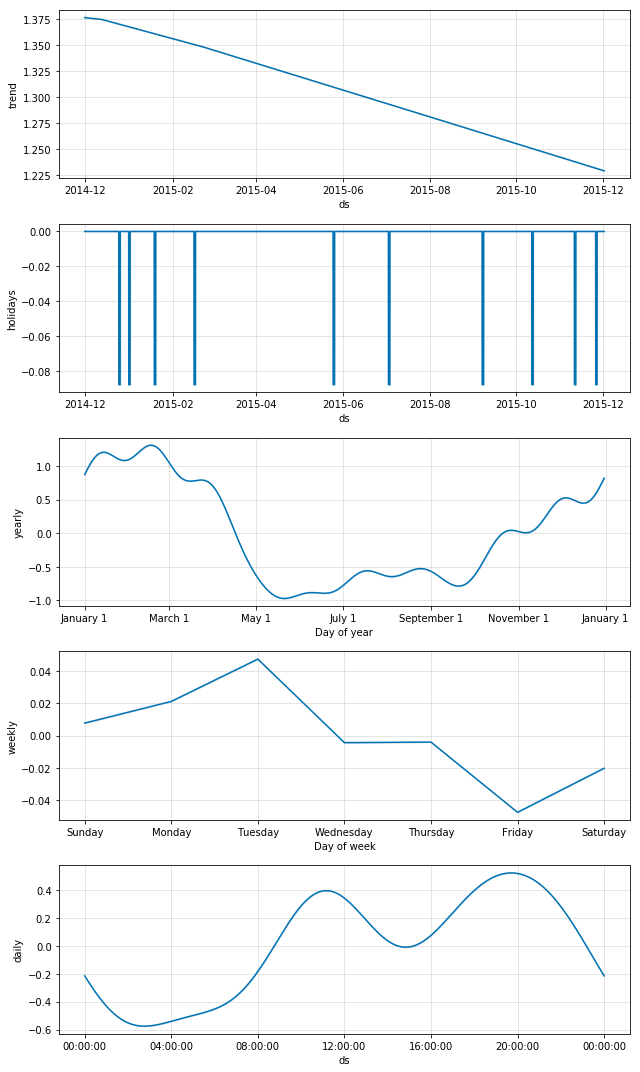

In [193]:
fig2 = m.plot_components(forecast)

In [201]:
import warnings
import statsmodels.api as sm

p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(X_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:119124.91817569251
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:108380.59434665389
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:103416.5647521714
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:87268.15985028881
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:98907.50661362949
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:87291.16870127755
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:97436.24424145475
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:86982.37548532384
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:103589.3236026938
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:98611.38757973154
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:100732.95435511532
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:83404.4566446202
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:94311.80987337093
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:83427.28809266748
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 

/Users/rishabhjain/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:81101.94964858294
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:92265.6447766008
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:81082.78661719288
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:87894.72063617925
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:87860.94949240994
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:107560.59119295499
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:87909.15800712793
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:87860.94777857968
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:87862.94780770938
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:99409.8924074393
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:87911.03192375867
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:81406.13734572828
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:81376.91722596844
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:100296.46581036299
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:81425.50329015765
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:81379.33277735731
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:81372.73808536894
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:93393.99579508725
ARIMA(1, 1

In [216]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

model = SARIMAX(X_train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
#model = SARIMAX(X_train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)
linear_reg_predicted_Y = model_fit.predict(len(X_train), len(X_train)+95)
print(len(linear_reg_predicted_Y), len(X_test))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, linear_reg_predicted_Y))


96 96
Mean Absolute Error : 0.55814


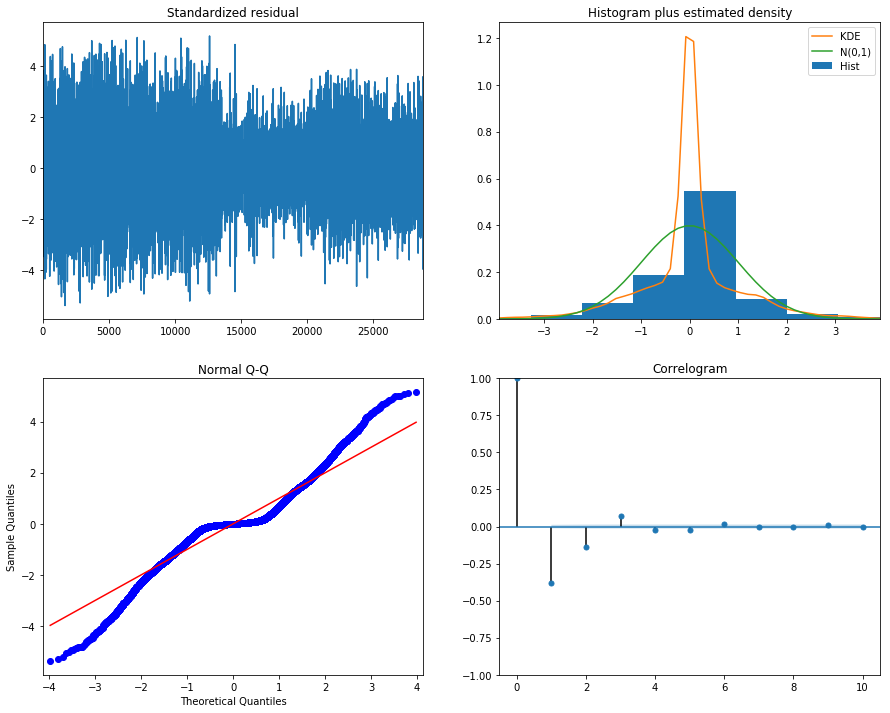

In [217]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()